In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

In [ ]:

def torch_stats():
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')
        # dtype = torch.cuda.FloatTensor

    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)

    num_workers=os.cpu_count()
    print ('available number of workers (CPU cores):',num_workers)

    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn

In [ ]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.2
Using device: cpu
default data type: torch.float32
available number of workers (CPU cores): 2


Мы загрузим предобученную версию модели (аргумент pretrained=True).

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
summary(model,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
for name,_ in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
import os
from torchvision.datasets.utils import download_and_extract_archive

In [ ]:
dataset_directory = '/content/drive/MyDrive/2_semestr/PP/dataset'

In [ ]:
content = os.listdir('/content/drive/MyDrive/2_semestr/PP/dataset')
print(content)
for dir_ in content:
    path_ = os.path.join(dataset_directory,dir_)
    if os.path.isdir(path_):
        print(dir_, ':\t', os.listdir(path_ ) )

['train', 'test', 'val']
train :	 ['unhealthy', 'healthy']
test :	 ['healthy', 'unhealthy']
val :	 ['healthy', 'unhealthy']


In [ ]:
train_transform =  transforms.Compose([
        transforms.RandomResizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

traindata = datasets.ImageFolder(os.path.join(dataset_directory, 'train'),train_transform)

valdata   = datasets.ImageFolder(os.path.join(dataset_directory, 'val'),test_transform)

names_classes = traindata.classes
print(names_classes)

print(f'Number of training examples: {len(traindata)}')
print(f'Number of validation examples: {len(valdata)}')

['healthy', 'unhealthy']
Number of training examples: 481
Number of validation examples: 70


In [ ]:
BATCH_SIZE = 8
if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
    kwarg = {'num_workers':min(BATCH_SIZE, num_workers)}

trainloader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=False, **kwarg)

valloader   = torch.utils.data.DataLoader(valdata, batch_size=BATCH_SIZE, shuffle=False, **kwarg)

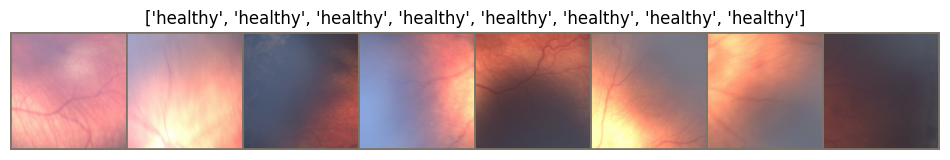

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12,4))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(valloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[names_classes[x] for x in classes])

In [ ]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.fc.in_features

model.fc = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0);

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 11177538
Number of all parameters for the model: 11177538


In [ ]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

In [ ]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

#-----------------------------
def train(model, dataloader, optimizer, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#--------------------------
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#-------------------

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion,accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

best epoch 0: Test Loss: 0.884 | Test Acc: 58.80%


In [ ]:
for p in model.layer4.named_modules():
    print(p[0])


0
0.conv1
0.bn1
0.relu
0.conv2
0.bn2
0.downsample
0.downsample.0
0.downsample.1
1
1.conv1
1.bn1
1.relu
1.conv2
1.bn2


In [ ]:
def init_weights(m):

    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if m.bias != None:
            m.bias.data.fill_(0)

In [ ]:
for  m in [model.layer4, model.fc]:
    for param in m.named_parameters():
        print(param[0])
        param[1].requires_grad = True
    m.apply(init_weights);

0.conv1.weight
0.bn1.weight
0.bn1.bias
0.conv2.weight
0.bn2.weight
0.bn2.bias
0.downsample.0.weight
0.downsample.1.weight
0.downsample.1.bias
1.conv1.weight
1.bn1.weight
1.bn1.bias
1.conv2.weight
1.bn2.weight
1.bn2.bias
weight
bias


In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 11177538


In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

best epoch 0: Test Loss: 1.150 | Test Acc: 87.50%


In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)


In [ ]:
trainable_parameters = []
for p in model.parameters():
    if p.requires_grad:
        trainable_parameters +=[p]

optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

In [ ]:
EPOCHS = 200

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   valloader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 19s
	Train Loss: 4.097 | Train Acc: 72.54%
	 Val. Loss: 5.576 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 20s
	Train Loss: 2.062 | Train Acc: 72.13%
	 Val. Loss: 0.389 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 18s
	Train Loss: 1.539 | Train Acc: 73.36%
	 Val. Loss: 1.036 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 16s
	Train Loss: 1.752 | Train Acc: 74.59%
	 Val. Loss: 0.533 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 17s
	Train Loss: 1.642 | Train Acc: 72.95%
	 Val. Loss: 15.112 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 20s
	Train Loss: 1.291 | Train Acc: 79.10%
	 Val. Loss: 0.623 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 16s
	Train Loss: 1.358 | Train Acc: 80.12%
	 Val. Loss: 0.970 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 15s
	Train Loss: 1.379 | Train Acc: 80.74%
	 Val. Loss: 4.149 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 17s
	Train Loss: 1.372 | Train Acc: 83.61%
	 Val. Loss: 1.682 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 15s
	Train Loss: 1.203 | Train Acc: 81.35%
	 Val. Loss: 2.496 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 1m 18s
	Train Loss: 1.088 | Train Acc: 84.22%
	 Val. Loss: 2.560 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 1m 19s
	Train Loss: 1.142 | Train Acc: 83.40%
	 Val. Loss: 0.482 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 1m 19s
	Train Loss: 1.052 | Train Acc: 83.81%
	 Val. Loss: 0.470 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 1m 20s
	Train Loss: 1.021 | Train Acc: 84.22%
	 Val. Loss: 1.372 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 1m 20s
	Train Loss: 1.037 | Train Acc: 84.84%
	 Val. Loss: 1.036 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 1m 21s
	Train Loss: 1.045 | Train Acc: 84.43%
	 Val. Loss: 3.035 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 1m 19s
	Train Loss: 1.035 | Train Acc: 84.02%
	 Val. Loss: 9.111 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 1m 21s
	Train Loss: 0.997 | Train Acc: 84.63%
	 Val. Loss: 1.953 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 1m 21s
	Train Loss: 1.027 | Train Acc: 84.02%
	 Val. Loss: 4.775 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 1m 15s
	Train Loss: 0.994 | Train Acc: 84.22%
	 Val. Loss: 1.134 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 1m 14s
	Train Loss: 0.894 | Train Acc: 84.22%
	 Val. Loss: 3.474 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 1m 14s
	Train Loss: 0.896 | Train Acc: 84.22%
	 Val. Loss: 1.385 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 1m 13s
	Train Loss: 0.938 | Train Acc: 84.63%
	 Val. Loss: 6.391 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 1m 17s
	Train Loss: 0.944 | Train Acc: 84.84%
	 Val. Loss: 2.588 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 1m 14s
	Train Loss: 0.868 | Train Acc: 84.02%
	 Val. Loss: 2.361 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 52 | Epoch Time: 1m 15s
	Train Loss: 0.771 | Train Acc: 84.63%
	 Val. Loss: 0.707 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 54 | Epoch Time: 1m 14s
	Train Loss: 0.798 | Train Acc: 84.63%
	 Val. Loss: 1.003 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 56 | Epoch Time: 1m 14s
	Train Loss: 0.720 | Train Acc: 84.63%
	 Val. Loss: 0.335 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 58 | Epoch Time: 1m 18s
	Train Loss: 0.776 | Train Acc: 84.63%
	 Val. Loss: 0.505 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 60 | Epoch Time: 1m 15s
	Train Loss: 0.742 | Train Acc: 84.22%
	 Val. Loss: 1.720 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 62 | Epoch Time: 1m 16s
	Train Loss: 0.656 | Train Acc: 86.07%
	 Val. Loss: 1.024 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 64 | Epoch Time: 1m 17s
	Train Loss: 0.742 | Train Acc: 84.63%
	 Val. Loss: 1.416 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 66 | Epoch Time: 1m 19s
	Train Loss: 0.664 | Train Acc: 86.68%
	 Val. Loss: 0.922 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 68 | Epoch Time: 1m 18s
	Train Loss: 0.612 | Train Acc: 86.89%
	 Val. Loss: 1.121 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 70 | Epoch Time: 1m 16s
	Train Loss: 0.685 | Train Acc: 86.89%
	 Val. Loss: 2.270 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 72 | Epoch Time: 1m 16s
	Train Loss: 0.736 | Train Acc: 86.48%
	 Val. Loss: 2.002 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 74 | Epoch Time: 1m 17s
	Train Loss: 0.630 | Train Acc: 85.04%
	 Val. Loss: 0.751 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 76 | Epoch Time: 1m 16s
	Train Loss: 0.691 | Train Acc: 86.27%
	 Val. Loss: 1.269 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 78 | Epoch Time: 1m 17s
	Train Loss: 0.574 | Train Acc: 87.09%
	 Val. Loss: 0.573 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 80 | Epoch Time: 1m 17s
	Train Loss: 0.660 | Train Acc: 86.48%
	 Val. Loss: 0.723 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 82 | Epoch Time: 1m 19s
	Train Loss: 0.609 | Train Acc: 86.68%
	 Val. Loss: 0.617 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 84 | Epoch Time: 1m 19s
	Train Loss: 0.641 | Train Acc: 86.48%
	 Val. Loss: 2.035 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 86 | Epoch Time: 1m 16s
	Train Loss: 0.584 | Train Acc: 86.48%
	 Val. Loss: 0.623 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 88 | Epoch Time: 1m 16s
	Train Loss: 0.697 | Train Acc: 85.66%
	 Val. Loss: 1.985 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 90 | Epoch Time: 1m 16s
	Train Loss: 0.591 | Train Acc: 87.09%
	 Val. Loss: 1.128 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 92 | Epoch Time: 1m 18s
	Train Loss: 0.630 | Train Acc: 86.68%
	 Val. Loss: 0.804 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 94 | Epoch Time: 1m 18s
	Train Loss: 0.637 | Train Acc: 84.63%
	 Val. Loss: 1.543 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 96 | Epoch Time: 1m 17s
	Train Loss: 0.560 | Train Acc: 87.09%
	 Val. Loss: 1.201 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 98 | Epoch Time: 1m 16s
	Train Loss: 0.656 | Train Acc: 86.27%
	 Val. Loss: 1.389 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 100 | Epoch Time: 1m 17s
	Train Loss: 0.582 | Train Acc: 86.48%
	 Val. Loss: 0.660 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 102 | Epoch Time: 1m 16s
	Train Loss: 0.552 | Train Acc: 87.09%
	 Val. Loss: 0.480 |  Val. Acc: 87.96%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 104 | Epoch Time: 1m 17s
	Train Loss: 0.558 | Train Acc: 86.48%
	 Val. Loss: 0.483 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 106 | Epoch Time: 1m 17s
	Train Loss: 0.681 | Train Acc: 85.86%
	 Val. Loss: 0.875 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 108 | Epoch Time: 1m 18s
	Train Loss: 0.564 | Train Acc: 86.68%
	 Val. Loss: 0.751 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 110 | Epoch Time: 1m 18s
	Train Loss: 0.562 | Train Acc: 86.68%
	 Val. Loss: 0.638 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 112 | Epoch Time: 1m 22s
	Train Loss: 0.578 | Train Acc: 86.48%
	 Val. Loss: 1.171 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 114 | Epoch Time: 1m 18s
	Train Loss: 0.520 | Train Acc: 87.30%
	 Val. Loss: 0.438 |  Val. Acc: 84.26%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 116 | Epoch Time: 1m 17s
	Train Loss: 0.491 | Train Acc: 87.70%
	 Val. Loss: 0.337 |  Val. Acc: 89.81%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 118 | Epoch Time: 1m 18s
	Train Loss: 0.522 | Train Acc: 86.68%
	 Val. Loss: 0.556 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 120 | Epoch Time: 1m 19s
	Train Loss: 0.522 | Train Acc: 86.89%
	 Val. Loss: 0.326 |  Val. Acc: 90.74%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 122 | Epoch Time: 1m 17s
	Train Loss: 0.535 | Train Acc: 86.27%
	 Val. Loss: 0.641 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 124 | Epoch Time: 1m 17s
	Train Loss: 0.539 | Train Acc: 86.68%
	 Val. Loss: 1.152 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 126 | Epoch Time: 1m 15s
	Train Loss: 0.529 | Train Acc: 87.30%
	 Val. Loss: 0.842 |  Val. Acc: 84.72%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 128 | Epoch Time: 1m 20s
	Train Loss: 0.566 | Train Acc: 86.68%
	 Val. Loss: 0.960 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 130 | Epoch Time: 1m 17s
	Train Loss: 0.489 | Train Acc: 87.09%
	 Val. Loss: 1.293 |  Val. Acc: 69.91%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 132 | Epoch Time: 1m 17s
	Train Loss: 0.545 | Train Acc: 86.68%
	 Val. Loss: 1.516 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 134 | Epoch Time: 1m 16s
	Train Loss: 0.543 | Train Acc: 87.09%
	 Val. Loss: 1.144 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 136 | Epoch Time: 1m 15s
	Train Loss: 0.600 | Train Acc: 86.48%
	 Val. Loss: 0.674 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 138 | Epoch Time: 1m 19s
	Train Loss: 0.564 | Train Acc: 86.27%
	 Val. Loss: 0.366 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 140 | Epoch Time: 1m 18s
	Train Loss: 0.553 | Train Acc: 86.48%
	 Val. Loss: 0.624 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 142 | Epoch Time: 1m 16s
	Train Loss: 0.527 | Train Acc: 87.09%
	 Val. Loss: 0.370 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 144 | Epoch Time: 1m 16s
	Train Loss: 0.551 | Train Acc: 87.09%
	 Val. Loss: 0.344 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 146 | Epoch Time: 1m 15s
	Train Loss: 0.528 | Train Acc: 86.68%
	 Val. Loss: 0.334 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 148 | Epoch Time: 1m 18s
	Train Loss: 0.535 | Train Acc: 86.48%
	 Val. Loss: 0.678 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 150 | Epoch Time: 1m 17s
	Train Loss: 0.490 | Train Acc: 86.89%
	 Val. Loss: 0.588 |  Val. Acc: 83.33%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 152 | Epoch Time: 1m 17s
	Train Loss: 0.494 | Train Acc: 86.68%
	 Val. Loss: 0.888 |  Val. Acc: 79.17%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 154 | Epoch Time: 1m 18s
	Train Loss: 0.531 | Train Acc: 86.68%
	 Val. Loss: 0.841 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 156 | Epoch Time: 1m 16s
	Train Loss: 0.508 | Train Acc: 86.68%
	 Val. Loss: 0.365 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 158 | Epoch Time: 1m 18s
	Train Loss: 0.483 | Train Acc: 87.50%
	 Val. Loss: 0.607 |  Val. Acc: 87.50%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 160 | Epoch Time: 1m 16s
	Train Loss: 0.477 | Train Acc: 87.30%
	 Val. Loss: 0.602 |  Val. Acc: 80.56%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 162 | Epoch Time: 1m 15s
	Train Loss: 0.517 | Train Acc: 87.09%
	 Val. Loss: 0.957 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 164 | Epoch Time: 1m 15s
	Train Loss: 0.470 | Train Acc: 87.09%
	 Val. Loss: 0.607 |  Val. Acc: 80.56%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 166 | Epoch Time: 1m 18s
	Train Loss: 0.481 | Train Acc: 87.50%
	 Val. Loss: 0.878 |  Val. Acc: 86.11%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 168 | Epoch Time: 1m 18s
	Train Loss: 0.562 | Train Acc: 86.89%
	 Val. Loss: 0.398 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 170 | Epoch Time: 1m 17s
	Train Loss: 0.450 | Train Acc: 86.89%
	 Val. Loss: 1.079 |  Val. Acc: 76.85%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 172 | Epoch Time: 1m 15s
	Train Loss: 0.432 | Train Acc: 87.50%
	 Val. Loss: 1.610 |  Val. Acc: 82.87%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 174 | Epoch Time: 1m 14s
	Train Loss: 0.502 | Train Acc: 87.09%
	 Val. Loss: 1.365 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 176 | Epoch Time: 1m 16s
	Train Loss: 0.490 | Train Acc: 86.89%
	 Val. Loss: 0.352 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 178 | Epoch Time: 1m 14s
	Train Loss: 0.507 | Train Acc: 87.30%
	 Val. Loss: 0.752 |  Val. Acc: 86.11%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 180 | Epoch Time: 1m 15s
	Train Loss: 0.528 | Train Acc: 86.48%
	 Val. Loss: 1.074 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 182 | Epoch Time: 1m 16s
	Train Loss: 0.469 | Train Acc: 87.09%
	 Val. Loss: 1.037 |  Val. Acc: 86.11%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 184 | Epoch Time: 1m 17s
	Train Loss: 0.475 | Train Acc: 86.68%
	 Val. Loss: 1.343 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 186 | Epoch Time: 1m 20s
	Train Loss: 0.474 | Train Acc: 87.50%
	 Val. Loss: 1.667 |  Val. Acc: 81.94%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 188 | Epoch Time: 1m 19s
	Train Loss: 0.455 | Train Acc: 87.30%
	 Val. Loss: 1.473 |  Val. Acc: 84.72%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 190 | Epoch Time: 1m 17s
	Train Loss: 0.508 | Train Acc: 86.89%
	 Val. Loss: 0.957 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 192 | Epoch Time: 1m 16s
	Train Loss: 0.447 | Train Acc: 87.70%
	 Val. Loss: 0.872 |  Val. Acc: 83.80%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 194 | Epoch Time: 1m 16s
	Train Loss: 0.440 | Train Acc: 87.30%
	 Val. Loss: 1.154 |  Val. Acc: 83.80%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 196 | Epoch Time: 1m 12s
	Train Loss: 0.536 | Train Acc: 87.09%
	 Val. Loss: 0.359 |  Val. Acc: 88.89%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 198 | Epoch Time: 1m 13s
	Train Loss: 0.534 | Train Acc: 87.09%
	 Val. Loss: 3.624 |  Val. Acc: 74.54%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 200 | Epoch Time: 1m 14s
	Train Loss: 0.499 | Train Acc: 86.68%
	 Val. Loss: 0.363 |  Val. Acc: 88.43%


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

-------------------- 
best epoch 138: Test Loss: 0.315 | Test Acc: 90.74%
